# Day 7: Advanced Volatility - Interview Questions & Review

## Week 7 Summary
This week covered advanced volatility modeling including GARCH variants, multivariate models, forecasting, and trading strategies.

## Topics Covered
- Day 1: GARCH(1,1) fundamentals
- Day 2: EGARCH and leverage effect
- Day 3: GJR-GARCH and threshold models
- Day 4: DCC-GARCH (multivariate)
- Day 5: Volatility forecasting comparison
- Day 6: Volatility trading strategies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna() * 100

stock = 'SPY'
ret = returns[stock].dropna()

print("="*60)
print("WEEK 7 REVIEW: ADVANCED VOLATILITY")
print("="*60)

WEEK 7 REVIEW: ADVANCED VOLATILITY


## Interview Question 1: Explain GARCH(1,1)

**Q: What is GARCH(1,1) and what does each parameter mean?**

In [2]:
# Answer with demonstration
model = arch_model(ret, vol='GARCH', p=1, q=1)
result = model.fit(disp='off')

print("\n📝 GARCH(1,1) Equation:")
print("σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁")

print("\nParameter Interpretation:")
omega = result.params['omega']
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']

print(f"  ω (omega) = {omega:.6f}")
print(f"    → Long-run average variance component")
print(f"  α (alpha) = {alpha:.4f}")
print(f"    → Weight on yesterday's squared shock (ARCH effect)")
print(f"    → Measures how strongly new information affects volatility")
print(f"  β (beta) = {beta:.4f}")
print(f"    → Weight on yesterday's variance (GARCH effect)")
print(f"    → Measures volatility persistence")

# Key metrics
persistence = alpha + beta
long_run_var = omega / (1 - persistence)
long_run_vol = np.sqrt(long_run_var) * np.sqrt(TRADING_DAYS)
half_life = np.log(0.5) / np.log(persistence)

print(f"\n📊 Key Derived Metrics:")
print(f"  Persistence (α + β) = {persistence:.4f}")
print(f"  Long-run volatility = {long_run_vol:.2f}% annualized")
print(f"  Half-life = {half_life:.1f} days")


📝 GARCH(1,1) Equation:
σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁

Parameter Interpretation:
  ω (omega) = 0.044896
    → Long-run average variance component
  α (alpha) = 0.1661
    → Weight on yesterday's squared shock (ARCH effect)
    → Measures how strongly new information affects volatility
  β (beta) = 0.8002
    → Weight on yesterday's variance (GARCH effect)
    → Measures volatility persistence

📊 Key Derived Metrics:
  Persistence (α + β) = 0.9663
  Long-run volatility = 18.32% annualized
  Half-life = 20.2 days


## Interview Question 2: Leverage Effect

**Q: What is the leverage effect and how do different GARCH models capture it?**

In [3]:
# Compare leverage effect in different models
print("\n📝 The Leverage Effect:")
print("→ Negative returns tend to increase volatility more than positive returns")
print("→ Named after financial leverage: falling prices → higher debt/equity → more risk")

# Fit asymmetric models
egarch = arch_model(ret, vol='EGARCH', p=1, o=1, q=1).fit(disp='off')
gjr = arch_model(ret, vol='GARCH', p=1, o=1, q=1).fit(disp='off')

print("\n📊 Model Comparison:")
print("\n1. EGARCH:")
print(f"   γ (gamma) = {egarch.params['gamma[1]']:.4f}")
print(f"   → Negative γ means negative shocks have LARGER impact")

print("\n2. GJR-GARCH:")
print(f"   γ (gamma) = {gjr.params['gamma[1]']:.4f}")
print(f"   → Positive γ means additional impact from negative shocks")
print(f"   → Negative shock impact: α + γ = {gjr.params['alpha[1]'] + gjr.params['gamma[1]']:.4f}")
print(f"   → Positive shock impact: α = {gjr.params['alpha[1]']:.4f}")


📝 The Leverage Effect:
→ Negative returns tend to increase volatility more than positive returns
→ Named after financial leverage: falling prices → higher debt/equity → more risk

📊 Model Comparison:

1. EGARCH:
   γ (gamma) = -0.1578
   → Negative γ means negative shocks have LARGER impact

2. GJR-GARCH:
   γ (gamma) = 0.2163
   → Positive γ means additional impact from negative shocks
   → Negative shock impact: α + γ = 0.2538
   → Positive shock impact: α = 0.0375


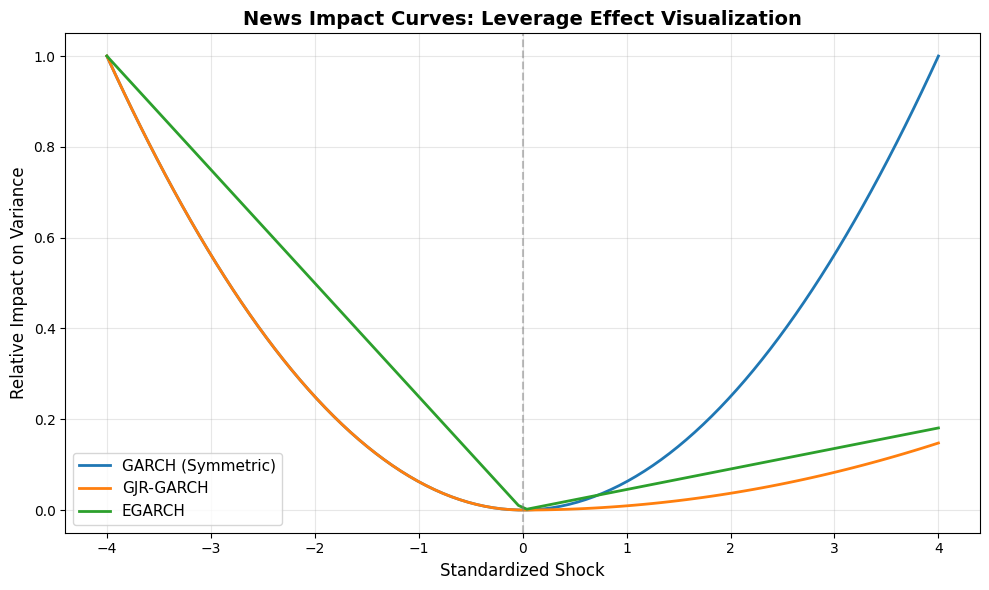

In [4]:
# Visual demonstration
shock_range = np.linspace(-4, 4, 100)
sigma = 1

# GARCH: symmetric
garch_impact = shock_range**2

# GJR-GARCH
alpha_gjr = gjr.params['alpha[1]']
gamma_gjr = gjr.params['gamma[1]']
gjr_impact = alpha_gjr * shock_range**2 + gamma_gjr * (shock_range < 0) * shock_range**2

# EGARCH
alpha_e = egarch.params['alpha[1]']
gamma_e = egarch.params['gamma[1]']
egarch_impact = alpha_e * np.abs(shock_range) + gamma_e * shock_range

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(shock_range, garch_impact / garch_impact.max(), label='GARCH (Symmetric)', linewidth=2)
ax.plot(shock_range, gjr_impact / gjr_impact.max(), label='GJR-GARCH', linewidth=2)
ax.plot(shock_range, egarch_impact / egarch_impact.max(), label='EGARCH', linewidth=2)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Standardized Shock', fontsize=12)
ax.set_ylabel('Relative Impact on Variance', fontsize=12)
ax.set_title('News Impact Curves: Leverage Effect Visualization', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interview Question 3: DCC-GARCH

**Q: Why do we need DCC-GARCH instead of using constant correlations?**

In [5]:
print("\n📝 DCC-GARCH (Dynamic Conditional Correlation):")
print("\nWhy time-varying correlations matter:")
print("1. Correlations SPIKE during market stress")
print("2. Diversification fails when you need it most")
print("3. Constant correlation underestimates tail risk")

# Demonstrate with data
spy = returns['SPY']
aapl = returns['AAPL']

# Rolling correlation
roll_corr = spy.rolling(60).corr(aapl)

# Correlation vs volatility
spy_vol = spy.rolling(20).std() * np.sqrt(TRADING_DAYS)

print(f"\n📊 Empirical Evidence:")
print(f"Correlation range: {roll_corr.min():.3f} to {roll_corr.max():.3f}")
print(f"Unconditional correlation: {spy.corr(aapl):.3f}")

# Correlation in high vs low vol regimes
high_vol = spy_vol > spy_vol.quantile(0.75)
low_vol = spy_vol < spy_vol.quantile(0.25)

print(f"\nCorrelation by volatility regime:")
print(f"  High vol periods: {roll_corr[high_vol].mean():.3f}")
print(f"  Low vol periods:  {roll_corr[low_vol].mean():.3f}")
print(f"\n→ Correlation increases during high volatility!")


📝 DCC-GARCH (Dynamic Conditional Correlation):

Why time-varying correlations matter:
1. Correlations SPIKE during market stress
2. Diversification fails when you need it most
3. Constant correlation underestimates tail risk

📊 Empirical Evidence:
Correlation range: 0.316 to 0.957
Unconditional correlation: 0.777

Correlation by volatility regime:
  High vol periods: 0.831
  Low vol periods:  0.636

→ Correlation increases during high volatility!


## Interview Question 4: Volatility Forecasting

**Q: How do you evaluate volatility forecasts? What metrics do you use?**

In [6]:
print("\n📝 Volatility Forecast Evaluation:")
print("\n1. RMSE (Root Mean Squared Error)")
print("   → Lower is better")
print("   → Penalizes large errors more")

print("\n2. MAE (Mean Absolute Error)")
print("   → Lower is better")
print("   → More robust to outliers")

print("\n3. Mincer-Zarnowitz Regression")
print("   → Regress realized on forecast")
print("   → Efficient forecast: intercept=0, slope=1")

print("\n4. QLIKE (Quasi-Likelihood)")
print("   → Specifically designed for variance forecasts")
print("   → Asymmetric loss function")

# Quick demonstration
garch_model = arch_model(ret, vol='GARCH', p=1, q=1)
garch_result = garch_model.fit(disp='off')
garch_vol = garch_result.conditional_volatility * np.sqrt(TRADING_DAYS)

# Realized vol (forward looking)
realized_vol = ret.rolling(20).std().shift(-20) * np.sqrt(TRADING_DAYS)

# Align
common = garch_vol.dropna().index.intersection(realized_vol.dropna().index)
forecast = garch_vol.loc[common]
target = realized_vol.loc[common]

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(target, forecast))
mae = mean_absolute_error(target, forecast)
corr = np.corrcoef(target, forecast)[0, 1]

print(f"\n📊 GARCH Forecast Evaluation:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE:  {mae:.2f}")
print(f"  Correlation: {corr:.3f}")


📝 Volatility Forecast Evaluation:

1. RMSE (Root Mean Squared Error)
   → Lower is better
   → Penalizes large errors more

2. MAE (Mean Absolute Error)
   → Lower is better
   → More robust to outliers

3. Mincer-Zarnowitz Regression
   → Regress realized on forecast
   → Efficient forecast: intercept=0, slope=1

4. QLIKE (Quasi-Likelihood)
   → Specifically designed for variance forecasts
   → Asymmetric loss function



📊 GARCH Forecast Evaluation:
  RMSE: 10.06
  MAE:  5.89
  Correlation: 0.544


## Interview Question 5: Volatility Trading

**Q: Describe a volatility-based trading strategy.**

In [7]:
print("\n📝 Volatility Trading Strategies:")

print("\n1. LOW VOLATILITY ANOMALY")
print("   Strategy: Long low-vol stocks, short high-vol stocks")
print("   Rationale: Low-vol stocks have better risk-adjusted returns")
print("   Implementation: Rank by 60-day vol, rebalance monthly")

print("\n2. VOLATILITY TARGETING")
print("   Strategy: Adjust position size to maintain constant vol")
print("   Formula: Weight = Target Vol / Forecast Vol")
print("   Benefit: Consistent risk exposure over time")

print("\n3. REGIME SWITCHING")
print("   Strategy: Reduce exposure in high-vol regimes")
print("   Implementation: Use vol percentiles to define regimes")
print("   Benefit: Avoid worst drawdowns")

print("\n4. VOLATILITY RISK PREMIUM (VRP)")
print("   Strategy: Sell options when implied > realized")
print("   Proxy: Long stocks when GARCH forecast > realized vol")
print("   Rationale: Implied vol typically overestimates realized")


📝 Volatility Trading Strategies:

1. LOW VOLATILITY ANOMALY
   Strategy: Long low-vol stocks, short high-vol stocks
   Rationale: Low-vol stocks have better risk-adjusted returns
   Implementation: Rank by 60-day vol, rebalance monthly

2. VOLATILITY TARGETING
   Strategy: Adjust position size to maintain constant vol
   Formula: Weight = Target Vol / Forecast Vol
   Benefit: Consistent risk exposure over time

3. REGIME SWITCHING
   Strategy: Reduce exposure in high-vol regimes
   Implementation: Use vol percentiles to define regimes
   Benefit: Avoid worst drawdowns

4. VOLATILITY RISK PREMIUM (VRP)
   Strategy: Sell options when implied > realized
   Proxy: Long stocks when GARCH forecast > realized vol
   Rationale: Implied vol typically overestimates realized


In [8]:
# Quick vol targeting example
target_vol = 15  # 15%
forecast_vol = garch_vol

# Weight = target / forecast
weight = target_vol / forecast_vol
weight = weight.clip(0.25, 2.0)  # Limit leverage
weight = weight.shift(1)  # No look-ahead

# Strategy returns
vol_target_returns = (ret / 100) * weight
vol_target_returns = vol_target_returns.dropna()
unlevered = (ret / 100).loc[vol_target_returns.index]

# Stats
print("\n📊 Vol Targeting Example (Target: 15%):")
print(f"Strategy Sharpe: {(vol_target_returns.mean() / vol_target_returns.std()) * np.sqrt(TRADING_DAYS):.3f}")
print(f"Unlevered Sharpe: {(unlevered.mean() / unlevered.std()) * np.sqrt(TRADING_DAYS):.3f}")


📊 Vol Targeting Example (Target: 15%):
Strategy Sharpe: 1.039
Unlevered Sharpe: 0.912


## Quick Reference: Key Formulas

### GARCH(1,1)
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### EGARCH
$$\ln(\sigma_t^2) = \omega + \alpha |z_{t-1}| + \gamma z_{t-1} + \beta \ln(\sigma_{t-1}^2)$$

### GJR-GARCH
$$\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### DCC
$$Q_t = (1-a-b)\bar{Q} + a(z_{t-1}z_{t-1}') + b Q_{t-1}$$

### Key Metrics
- **Persistence**: $\alpha + \beta$ (close to 1 = high persistence)
- **Half-life**: $\ln(0.5) / \ln(\alpha + \beta)$
- **Unconditional variance**: $\omega / (1 - \alpha - \beta)$

In [9]:
print("\n" + "="*60)
print("WEEK 7 COMPLETE: ADVANCED VOLATILITY")
print("="*60)
print("\n✅ Key Skills Acquired:")
print("   1. GARCH model fitting and interpretation")
print("   2. Asymmetric models (EGARCH, GJR-GARCH)")
print("   3. Multivariate volatility (DCC)")
print("   4. Forecast evaluation")
print("   5. Volatility trading strategies")
print("\n📚 Next Week: Deep Learning Fundamentals")


WEEK 7 COMPLETE: ADVANCED VOLATILITY

✅ Key Skills Acquired:
   1. GARCH model fitting and interpretation
   2. Asymmetric models (EGARCH, GJR-GARCH)
   3. Multivariate volatility (DCC)
   4. Forecast evaluation
   5. Volatility trading strategies

📚 Next Week: Deep Learning Fundamentals
